# Modules, colors, and functions

### Remove scroll from figures

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Extend the size of the Window

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Load Modules

In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import convolution as conv
from astropy.time import Time
import datetime
import glob
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from pprint import pprint
import scipy as sp
from scipy.interpolate import griddata
from scipy import sparse, signal, stats
import sunpy.cm as cm
import sunpy.map
import sunpy.physics.differential_rotation as dr
import torch.nn.functional as F

import sys, os

os.environ["CUDA_VISIBLE_DEVICES"]=""

sys.path.append("../../../")
from source.pipeline.model_manager import BaseScaler
from source.pipeline.models.highresnet import HighResNet
from source.pipeline.models.highresnet_rprc import HighResNet_RPRC
from source.pipeline.losses.baseline_loss import MSELoss, L1Loss
from source.pipeline.entropy import Entropy

from source.patch_stitch import get_patch
from source.patch_stitch import get_img_from_patch
from source.multiframe import register

from skimage.transform import resize

import torch
import torch.nn as nn
from torch.nn import functional as F
import yaml

%matplotlib inline

### Load and interface with Google Cloud Storage

In [4]:
# Imports the Google Cloud client library
from google.cloud import storage

# Instantiates a client
client = storage.Client()

### Remove Warnings and Define Color Defaults

You can switch colormaps between *hmimag* (*seismic*) if you want to focus on the *weak* (*strong*) magnetic features.

In [5]:
# Remove Warnings
# import warnings
# warnings.filterwarnings('ignore')

# Color Axis limits
vmin = -2000
vmax = 2000

# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

# Colormap Definition
current_cmap = plt.cm.get_cmap('hmimag')
# current_cmap = plt.cm.get_cmap('seismic')
current_cmap.set_bad(color='black')

device = torch.device('cpu')

## Load Target HMI magnetogram

In [6]:
hmi_bucket = 'hmi-fits'
# hmi_file = 'hmi-data/hmi-prep/2011/4/1/HMI_20110401-014618.fits'
# New data test bucket
hmi_file = 'hmi-data/hmi-prep/2011/3/13/HMI_20110313-031015.fits'


bucket = client.get_bucket(hmi_bucket)
blob = bucket.blob(hmi_file)
file = blob.download_to_filename('/tmp/tmp_hmi.fits')

HMI_fits = fits.open('/tmp/tmp_hmi.fits', cache=False)
HMI_fits.verify('fix')

HMImap = sunpy.map.Map(HMI_fits[1].data, HMI_fits[1].header)
HMI_fits.close()

x, y = np.meshgrid(*[np.arange(v.value) for v in HMImap.dimensions]) * u.pixel
hpc_coords = HMImap.pixel_to_world(x, y)
rSunH = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / HMImap.rsun_obs

# Mask data and rSun array to be on disk only
HMImap.data[rSunH>0.985] = 0

## Assembling aligned patches and saving 2D scatter histogram

In [7]:
target_patch = get_patch(HMImap, 128, instrument=HMImap.detector, stride=128)
target_patch.shape

(1024, 2, 128, 128)

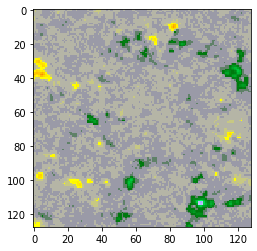

In [8]:
inx = 716
# inx = 410

## Target
fig = plt.figure(figsize=(4, 4))
plt.imshow(target_patch[inx,0,:,:], vmin=vmin, vmax=vmax, cmap=current_cmap)

In [9]:
tmp = torch.from_numpy(target_patch).to(device).float()
downscaled = F.avg_pool2d(tmp[inx,0,:,:][None], 2)

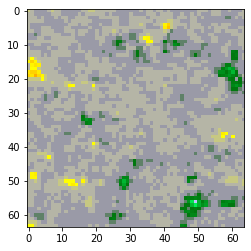

In [10]:
fig = plt.figure(figsize=(4, 4))
plt.imshow(downscaled[0,:,:], vmin=vmin, vmax=vmax, cmap=current_cmap)

In [11]:
downscaled.shape

torch.Size([1, 64, 64])